In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'enet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 758.62it/s]


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:10<00:00, 36.50img/s]

***
enet Loss: 1.1559231281280518


Epoch 1/50:  99%|█████████▊| 200/203 [00:15<00:00, 13.32img/s]


---
enet Validation Dice Loss: 1.0770692825317383
enet Validation Pixel Accuracy: 0.6976829662657621
enet Validation MIoU: 0.3931166597583482
enet Validation Dice Score: 0.18965588510036469


Epoch 2/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.50img/s]

***
enet Loss: 1.0543544292449951


Epoch 2/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.46img/s]


---
enet Validation Dice Loss: 1.0326869487762451
enet Validation Pixel Accuracy: 0.7111575478001645
enet Validation MIoU: 0.41581281104570395
enet Validation Dice Score: 0.2599775493144989


Epoch 3/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.88img/s]

***
enet Loss: 0.9602411389350891


Epoch 3/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.25img/s]


---
enet Validation Dice Loss: 0.94496750831604
enet Validation Pixel Accuracy: 0.7598360295881305
enet Validation MIoU: 0.4682927522850856
enet Validation Dice Score: 0.35350874066352844


Epoch 4/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.75img/s]

***
enet Loss: 0.8408001065254211


Epoch 4/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.18img/s]


---
enet Validation Dice Loss: 0.8439573645591736
enet Validation Pixel Accuracy: 0.8034809848718476
enet Validation MIoU: 0.5187714712119533
enet Validation Dice Score: 0.4291040599346161


Epoch 5/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.58img/s]

***
enet Loss: 0.7732263803482056


Epoch 5/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.85img/s]


---
enet Validation Dice Loss: 0.7558360695838928
enet Validation Pixel Accuracy: 0.8366174530564693
enet Validation MIoU: 0.5640881305209902
enet Validation Dice Score: 0.49880486726760864


Epoch 6/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.79img/s]

***
enet Loss: 0.7231778502464294


Epoch 6/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.31img/s]


---
enet Validation Dice Loss: 0.6891394853591919
enet Validation Pixel Accuracy: 0.8619090297765899
enet Validation MIoU: 0.6013634645712812
enet Validation Dice Score: 0.5444841980934143


Epoch 7/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.77img/s]

***
enet Loss: 0.6365432143211365


Epoch 7/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.07img/s]


---
enet Validation Dice Loss: 0.6300499439239502
enet Validation Pixel Accuracy: 0.8800370065789473
enet Validation MIoU: 0.6329925334930784
enet Validation Dice Score: 0.5850285887718201


Epoch 8/50:  99%|█████████▊| 200/203 [00:07<00:00, 34.43img/s]

***
enet Loss: 0.6145646572113037


Epoch 8/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.18img/s]


---
enet Validation Dice Loss: 0.5732362270355225
enet Validation Pixel Accuracy: 0.8924948709052906
enet Validation MIoU: 0.6578242057450588
enet Validation Dice Score: 0.6125594973564148


Epoch 9/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.24img/s]

***
enet Loss: 0.5584734082221985


Epoch 9/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.39img/s]


---
enet Validation Dice Loss: 0.533624529838562
enet Validation Pixel Accuracy: 0.8971383613452577
enet Validation MIoU: 0.6734846862008557
enet Validation Dice Score: 0.6406041979789734


Epoch 10/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.74img/s]

***
enet Loss: 0.5305979251861572


Epoch 10/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.91img/s]


---
enet Validation Dice Loss: 0.4855886697769165
enet Validation Pixel Accuracy: 0.9054088927151864
enet Validation MIoU: 0.6901657849649987
enet Validation Dice Score: 0.6726498603820801


Epoch 11/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.09img/s]

***
enet Loss: 0.49795547127723694


Epoch 11/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.72img/s]


---
enet Validation Dice Loss: 0.4617246687412262
enet Validation Pixel Accuracy: 0.9089596396998355
enet Validation MIoU: 0.7122692552127892
enet Validation Dice Score: 0.7058741450309753


Epoch 12/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.84img/s]

***
enet Loss: 0.4040917456150055


Epoch 12/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.45img/s]


---
enet Validation Dice Loss: 0.4269842207431793
enet Validation Pixel Accuracy: 0.9142686275013706
enet Validation MIoU: 0.7162197639236821
enet Validation Dice Score: 0.7200009822845459


Epoch 13/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.73img/s]

***
enet Loss: 0.41236427426338196


Epoch 13/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.67img/s]


---
enet Validation Dice Loss: 0.3997013568878174
enet Validation Pixel Accuracy: 0.9199430231462445
enet Validation MIoU: 0.7380942490683092
enet Validation Dice Score: 0.763849675655365


Epoch 14/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.13img/s]

***
enet Loss: 0.3809499740600586


Epoch 14/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.43img/s]


---
enet Validation Dice Loss: 0.3851128816604614
enet Validation Pixel Accuracy: 0.9288844058388158
enet Validation MIoU: 0.7765163965759109
enet Validation Dice Score: 0.7936338782310486


Epoch 15/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.44img/s]

***
enet Loss: 0.3629004657268524


Epoch 15/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.58img/s]


---
enet Validation Dice Loss: 0.35443443059921265
enet Validation Pixel Accuracy: 0.9348848577131305
enet Validation MIoU: 0.7909189624258396
enet Validation Dice Score: 0.8124355673789978


Epoch 16/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.04img/s]

***
enet Loss: 0.37659716606140137


Epoch 16/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.28img/s]


---
enet Validation Dice Loss: 0.33612507581710815
enet Validation Pixel Accuracy: 0.9371985719915021
enet Validation MIoU: 0.7886931469960284
enet Validation Dice Score: 0.807532012462616


Epoch 17/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.99img/s]

***
enet Loss: 0.2858639359474182


Epoch 17/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.60img/s]


---
enet Validation Dice Loss: 0.3266229033470154
enet Validation Pixel Accuracy: 0.941054762455455
enet Validation MIoU: 0.8120253910394164
enet Validation Dice Score: 0.83924400806427


Epoch 18/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.40img/s]

***
enet Loss: 0.2994586229324341


Epoch 18/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.00img/s]


---
enet Validation Dice Loss: 0.3168679177761078
enet Validation Pixel Accuracy: 0.9401820668003016
enet Validation MIoU: 0.8080184926936337
enet Validation Dice Score: 0.8435144424438477


Epoch 19/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.66img/s]

***
enet Loss: 0.3022981882095337


Epoch 19/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.53img/s]


---
enet Validation Dice Loss: 0.2969356179237366
enet Validation Pixel Accuracy: 0.945926867033306
enet Validation MIoU: 0.826270521353752
enet Validation Dice Score: 0.8466679453849792


Epoch 20/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.45img/s]

***
enet Loss: 0.33026665449142456


Epoch 20/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.24img/s]


---
enet Validation Dice Loss: 0.29033222794532776
enet Validation Pixel Accuracy: 0.9435253477933114
enet Validation MIoU: 0.8120129718442635
enet Validation Dice Score: 0.8563870787620544


Epoch 21/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.36img/s]

***
enet Loss: 0.3056538701057434


Epoch 21/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.48img/s]


---
enet Validation Dice Loss: 0.28238794207572937
enet Validation Pixel Accuracy: 0.9443123800712719
enet Validation MIoU: 0.817256898127335
enet Validation Dice Score: 0.8620375990867615


Epoch 22/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.84img/s]

***
enet Loss: 0.23639927804470062


Epoch 22/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.93img/s]


---
enet Validation Dice Loss: 0.28251636028289795
enet Validation Pixel Accuracy: 0.9443755568119517
enet Validation MIoU: 0.8221335064618707
enet Validation Dice Score: 0.8595293164253235


Epoch 23/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.51img/s]

***
enet Loss: 0.21427688002586365


Epoch 23/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.73img/s]


---
enet Validation Dice Loss: 0.2623589336872101
enet Validation Pixel Accuracy: 0.948378981205455
enet Validation MIoU: 0.8275810616186123
enet Validation Dice Score: 0.8506764769554138


Epoch 24/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.60img/s]

***
enet Loss: 0.2337074726819992


Epoch 24/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.31img/s]


---
enet Validation Dice Loss: 0.2563943564891815
enet Validation Pixel Accuracy: 0.9488364771792763
enet Validation MIoU: 0.8310993974382429
enet Validation Dice Score: 0.8547839522361755


Epoch 25/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.63img/s]

***
enet Loss: 0.24006173014640808


Epoch 25/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.18img/s]


---
enet Validation Dice Loss: 0.2625575065612793
enet Validation Pixel Accuracy: 0.9475418893914473
enet Validation MIoU: 0.8321645750204634
enet Validation Dice Score: 0.8622957468032837


Epoch 26/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.20img/s]

***
enet Loss: 0.21527382731437683


Epoch 26/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.76img/s]


---
enet Validation Dice Loss: 0.250718355178833
enet Validation Pixel Accuracy: 0.9511448374965734
enet Validation MIoU: 0.839276052834641
enet Validation Dice Score: 0.8667214512825012


Epoch 27/50:  99%|█████████▊| 200/203 [00:07<00:00, 39.17img/s]

***
enet Loss: 0.21812675893306732


Epoch 27/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.22img/s]


---
enet Validation Dice Loss: 0.25159937143325806
enet Validation Pixel Accuracy: 0.9499399285567435
enet Validation MIoU: 0.8358776062184355
enet Validation Dice Score: 0.8720369338989258


Epoch 28/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.08img/s]

***
enet Loss: 0.26870763301849365


Epoch 28/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.90img/s]


---
enet Validation Dice Loss: 0.253756046295166
enet Validation Pixel Accuracy: 0.949273895799068
enet Validation MIoU: 0.834764402696182
enet Validation Dice Score: 0.8714874386787415


Epoch 29/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.59img/s]

***
enet Loss: 0.23367683589458466


Epoch 29/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.83img/s]


---
enet Validation Dice Loss: 0.2547764182090759
enet Validation Pixel Accuracy: 0.9488894813939145
enet Validation MIoU: 0.8342787134871819
enet Validation Dice Score: 0.8712778091430664


Epoch 30/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.78img/s]

***
enet Loss: 0.23902402818202972


Epoch 30/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.80img/s]


---
enet Validation Dice Loss: 0.2512081265449524
enet Validation Pixel Accuracy: 0.94964599609375
enet Validation MIoU: 0.8355871071112917
enet Validation Dice Score: 0.8735260963439941


Epoch 31/50:  99%|█████████▊| 200/203 [00:07<00:00, 34.70img/s]

***
enet Loss: 0.22560323774814606


Epoch 31/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.05img/s]


---
enet Validation Dice Loss: 0.25254741311073303
enet Validation Pixel Accuracy: 0.9491151508532072
enet Validation MIoU: 0.8349513366052228
enet Validation Dice Score: 0.8729476928710938


Epoch 32/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.02img/s]

***
enet Loss: 0.215008944272995


Epoch 32/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.21img/s]


---
enet Validation Dice Loss: 0.25046104192733765
enet Validation Pixel Accuracy: 0.949999357524671
enet Validation MIoU: 0.8371722102187111
enet Validation Dice Score: 0.8695249557495117


Epoch 33/50:  99%|█████████▊| 200/203 [00:07<00:00, 37.32img/s]

***
enet Loss: 0.2057015299797058


Epoch 33/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.02img/s]


---
enet Validation Dice Loss: 0.2491256594657898
enet Validation Pixel Accuracy: 0.9501838014836896
enet Validation MIoU: 0.8381990086923734
enet Validation Dice Score: 0.8736675381660461


Epoch 34/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.58img/s]

***
enet Loss: 0.25802960991859436


Epoch 34/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.61img/s]


---
enet Validation Dice Loss: 0.2455700784921646
enet Validation Pixel Accuracy: 0.9509108693976152
enet Validation MIoU: 0.8388936707347101
enet Validation Dice Score: 0.8754779100418091


Epoch 35/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.13img/s]

***
enet Loss: 0.21011877059936523


Epoch 35/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.77img/s]


---
enet Validation Dice Loss: 0.24754813313484192
enet Validation Pixel Accuracy: 0.9501738966557017
enet Validation MIoU: 0.837805986057236
enet Validation Dice Score: 0.8749491572380066


Epoch 36/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.82img/s]

***
enet Loss: 0.1816236674785614


Epoch 36/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.05img/s]


---
enet Validation Dice Loss: 0.2481965273618698
enet Validation Pixel Accuracy: 0.9494561981736568
enet Validation MIoU: 0.8354676520259303
enet Validation Dice Score: 0.8774474263191223


Epoch 37/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.00img/s]

***
enet Loss: 0.24429409205913544


Epoch 37/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.04img/s]


---
enet Validation Dice Loss: 0.24368725717067719
enet Validation Pixel Accuracy: 0.9512272884971217
enet Validation MIoU: 0.8400385731038729
enet Validation Dice Score: 0.8730635643005371


Epoch 38/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.62img/s]

***
enet Loss: 0.2223731428384781


Epoch 38/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.05img/s]


---
enet Validation Dice Loss: 0.24697738885879517
enet Validation Pixel Accuracy: 0.9500047114857456
enet Validation MIoU: 0.8370728542051071
enet Validation Dice Score: 0.8755305409431458


Epoch 39/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.53img/s]

***
enet Loss: 0.21194958686828613


Epoch 39/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.87img/s]


---
enet Validation Dice Loss: 0.24561892449855804
enet Validation Pixel Accuracy: 0.9501390959087171
enet Validation MIoU: 0.8375267621115385
enet Validation Dice Score: 0.8762992024421692


Epoch 40/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.11img/s]

***
enet Loss: 0.20052602887153625


Epoch 40/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.78img/s]


---
enet Validation Dice Loss: 0.24552901089191437
enet Validation Pixel Accuracy: 0.9496818676329496
enet Validation MIoU: 0.836356662729466
enet Validation Dice Score: 0.8771311044692993


Epoch 41/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.73img/s]

***
enet Loss: 0.1799856722354889


Epoch 41/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.82img/s]


---
enet Validation Dice Loss: 0.2502392530441284
enet Validation Pixel Accuracy: 0.9485428124143366
enet Validation MIoU: 0.8340643220818035
enet Validation Dice Score: 0.8774517178535461


Epoch 42/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.60img/s]

***
enet Loss: 0.23966626822948456


Epoch 42/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.94img/s]


---
enet Validation Dice Loss: 0.2478904277086258
enet Validation Pixel Accuracy: 0.949136031301398
enet Validation MIoU: 0.8353407286241947
enet Validation Dice Score: 0.8770866394042969


Epoch 43/50:  99%|█████████▊| 200/203 [00:07<00:00, 36.21img/s]

***
enet Loss: 0.2568050026893616


Epoch 43/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.34img/s]


---
enet Validation Dice Loss: 0.2448311597108841
enet Validation Pixel Accuracy: 0.9502440335457785
enet Validation MIoU: 0.8375515613254366
enet Validation Dice Score: 0.878027081489563


Epoch 44/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.77img/s]

***
enet Loss: 0.21545514464378357


Epoch 44/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.11img/s]


---
enet Validation Dice Loss: 0.2488442361354828
enet Validation Pixel Accuracy: 0.948910629540159
enet Validation MIoU: 0.8348676205172849
enet Validation Dice Score: 0.8761332631111145


Epoch 45/50:  99%|█████████▊| 200/203 [00:07<00:00, 34.84img/s]

***
enet Loss: 0.21342498064041138


Epoch 45/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.96img/s]


---
enet Validation Dice Loss: 0.24464841187000275
enet Validation Pixel Accuracy: 0.949985704923931
enet Validation MIoU: 0.836670732917589
enet Validation Dice Score: 0.8781725764274597


Epoch 46/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.42img/s]

***
enet Loss: 0.1984381526708603


Epoch 46/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.41img/s]


---
enet Validation Dice Loss: 0.24393899738788605
enet Validation Pixel Accuracy: 0.9503446880139803
enet Validation MIoU: 0.8374470025556273
enet Validation Dice Score: 0.8787342309951782


Epoch 47/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.75img/s]

***
enet Loss: 0.19711953401565552


Epoch 47/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.68img/s]


---
enet Validation Dice Loss: 0.24420401453971863
enet Validation Pixel Accuracy: 0.9502638432017544
enet Validation MIoU: 0.8375833294180108
enet Validation Dice Score: 0.8794607520103455


Epoch 48/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.13img/s]

***
enet Loss: 0.22016273438930511


Epoch 48/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.87img/s]


---
enet Validation Dice Loss: 0.25019481778144836
enet Validation Pixel Accuracy: 0.9487181546395285
enet Validation MIoU: 0.8348084673430425
enet Validation Dice Score: 0.8763664364814758


Epoch 49/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.94img/s]

***
enet Loss: 0.2100527584552765


Epoch 49/50:  99%|█████████▊| 200/203 [00:10<00:00, 19.05img/s]


---
enet Validation Dice Loss: 0.24612103402614594
enet Validation Pixel Accuracy: 0.949624312551398
enet Validation MIoU: 0.8363309981011086
enet Validation Dice Score: 0.8780705332756042


Epoch 50/50:  99%|█████████▊| 200/203 [00:07<00:00, 35.57img/s]

***
enet Loss: 0.2255878895521164


Epoch 50/50:  99%|█████████▊| 200/203 [00:10<00:00, 18.91img/s]

---
enet Validation Dice Loss: 0.24377572536468506
enet Validation Pixel Accuracy: 0.9504014400013706
enet Validation MIoU: 0.837904041245098
enet Validation Dice Score: 0.8774591684341431


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

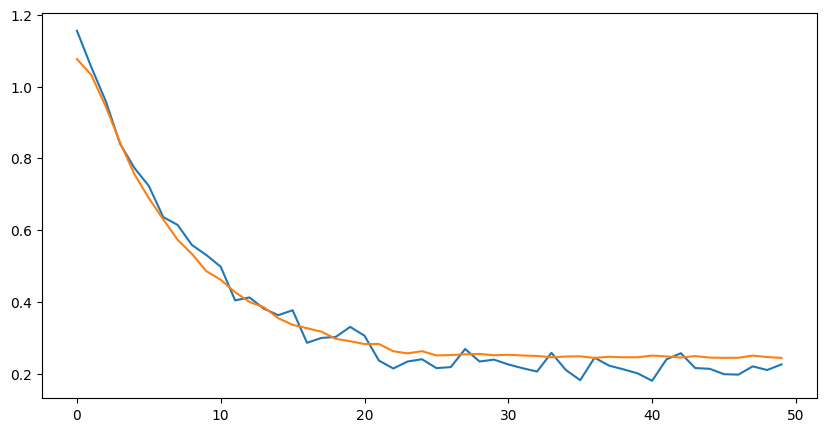

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

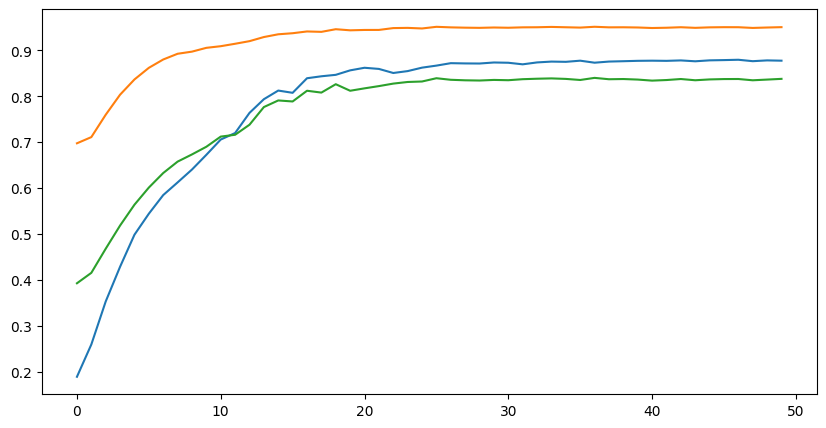

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)
#plt.show()